In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp

import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt

import os, sys

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import NativePerceptron
from perceptron import Perceptron

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


# Setting up the Problem

In [2]:
# setting up the problem
perceptron_qubits = 4
pulse_basis = 2*4
ts = jnp.array([1.0])
t = 1

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron =NativePerceptron(perceptron_qubits, pulse_basis, basis='fourier', pulse_width=0.005, native_coupling=1)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

# e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
# print(f'Exact ground state energy: {e_ground_state_exact}')


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]


I0000 00:00:1708986656.846917       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [3]:
perceptron.H

  (1*((PauliZ(wires=[0]) @ PauliZ(wires=[3])) + (PauliZ(wires=[1]) @ PauliZ(wires=[3])) + (PauliZ(wires=[2]) @ PauliZ(wires=[3]))))
+ (fourier_field(params_0, t)*(PauliX(wires=[0])))
+ (fourier_field(params_1, t)*(PauliX(wires=[1])))
+ (fourier_field(params_2, t)*(PauliX(wires=[2])))
+ (fourier_field(params_3, t)*(PauliX(wires=[3])))
+ (fourier_field(params_4, t)*(PauliY(wires=[0])))
+ (fourier_field(params_5, t)*(PauliY(wires=[1])))
+ (fourier_field(params_6, t)*(PauliY(wires=[2])))
+ (fourier_field(params_7, t)*(PauliY(wires=[3])))

In [4]:
V = qml.matrix(qml.evolve(H_obj, 1))

@jax.jit
def loss(param_vector):

    param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

    U = qml.matrix(qml.evolve(perceptron.H)(param_list, t))

    return qml.math.frobenius_inner_product(jnp.conjugate(U-V),U-V).real


In [5]:
perceptron.get_random_parameter_vector(78680)

Array([0.25703401, 0.95794489, 0.9315451 , 0.21982997, 0.07989672,
       0.82378447, 0.76845911, 0.32975037, 0.0411121 , 0.7507967 ,
       0.60668798, 0.73351756, 0.34244384, 0.59320246, 0.51619732,
       0.75986847, 0.84199611, 0.4007286 , 0.41215723, 0.05479216,
       0.56435878, 0.59173568, 0.7195821 , 0.55783444, 0.2715738 ,
       0.4786959 , 0.52160384, 0.61177807, 0.1059213 , 0.37146242,
       0.06849853, 0.38757868, 0.23232501, 0.52642851, 0.65688201,
       0.19662277, 0.89526878, 0.75692948, 0.08215422, 0.70341644,
       0.88259295, 0.2494096 , 0.66876747, 0.784708  , 0.15063363,
       0.22730058, 0.30901653, 0.02827656, 0.42743921, 0.5570453 ,
       0.29298136, 0.9216619 , 0.83361192, 0.5275031 , 0.68302377,
       0.03450286, 0.49935783, 0.02396676, 0.93657703, 0.63879929,
       0.0238281 , 0.5335222 , 0.81474135, 0.31680277], dtype=float64)

In [6]:
# getting the loss_function
# loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(89889)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.28682763 0.6848359  0.68853564 0.78089554 0.46313029 0.0201011
 0.81162074 0.60755771 0.15317525 0.70212681 0.35721124 0.51831341
 0.53005903 0.10897967 0.37118314 0.15520256 0.95319252 0.71612871
 0.62763862 0.3855253  0.87823275 0.3542904  0.77705782 0.83026368
 0.06613214 0.51331566 0.71599745 0.00519138 0.44388704 0.77807952
 0.57873248 0.21354189 0.3401097  0.01626898 0.37402742 0.9059025
 0.02169533 0.09533818 0.58867682 0.56669732 0.16944857 0.85279637
 0.29127174 0.07536813 0.82656284 0.21549241 0.45200478 0.12306324
 0.43816066 0.09370426 0.39224242 0.3763595  0.3261555  0.95302011
 0.64518511 0.89910384 0.46790566 0.21805174 0.39130751 0.85968716
 0.87938876 0.76603114 0.57868735 0.63913841]
Initial loss: 28.627219958077504
Initial gradients: [ 1.74781352e-01 -2.88610161e-02 -3.01757409e-03 -3.08162759e-03
 -2.36245259e-03  1.90500146e-05 -3.34926728e-04 -8.25388354e-04
 -2.12948429e-01  2.30273701e-02  4.78276605e-03  2.39417203e-03
  1.65883236e-03  4

TypeError: mul got incompatible shapes for broadcasting: (999,), (8,).

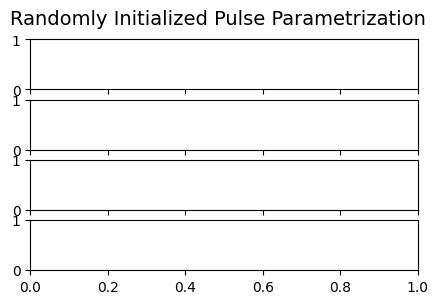

In [7]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, figsize=(5, 3), sharex=True)  # Adjusted figure size

fig.suptitle('Randomly Initialized Pulse Parametrization', fontsize=14)  # Larger title font

colors = ['teal', 'orange']  # Different colors for different plots

for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-", color='teal')
    ax.set_ylabel(f"{i} Field", fontsize=10)  # Set label with increased font size

    ax.grid(True)  # Adding gridlines

# Set label for the last plot
axs[-1].set_xlabel("time", fontsize=10)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust tight_layout to accommodate the suptitle
plt.show()


In [13]:
from datetime import datetime

n_epochs = 200
param_vector = perceptron.get_random_parameter_vector(808)


# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
# schedule0 = optax.constant_schedule(0.1)
# schedule1 = optax.constant_schedule(0.05)
# # schedule2 = optax.constant_schedule(0.001)
# # schedule = optax.join_schedules([schedule0, schedule1, schedule2], [200, 3000])
# schedule = optax.join_schedules([schedule0, schedule1], [200])

# optimizer = optax.adam(learning_rate=schedule)

# optimizer = optax.adam(learning_rate=0.1)

optimizer = optax.sgd(learning_rate=0.1)

# optimizer = optax.sgd(learning_rate=0.005)
# optimizer = optax.adabelief(0.1)
opt_state = optimizer.init(param_vector)

energies = np.zeros(n_epochs )
# energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)

gradients_trajectory = []
param_trajectory = []

# ## Compile the evaluation and gradient function and report compilation time
# time0 = time()
# _ = value_and_grad(param_vector)
# time1 = time()

# print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)

    mean_gradients[n] = np.mean(np.abs(grads))
    energies[n] = val
    param_trajectory.append(param_vector)
    gradients_trajectory.append(grads)

    param_vector = optax.apply_updates(param_vector, updates)

    print(val)

    # if not n % 10:
    #     print(f"{n+1} / {n_epochs}; Frobenius norm: {val}")
    #     print(f"    mean grad: {mean_gradients[n]}")
    #     print(f'    gradient norm: {jnp.linalg.norm(grads)}')
    #     if n>=2:
    #         print(f'    difference of gradients: {jnp.linalg.norm(grads-gradients_trajectory[-2])}')



print(f"Optimal Frobenius Norm Found: {energies[-1]}")


28.510119815920355
25.164569082953456
23.20214907776603
22.709842997517544
22.623617673511262
22.58223719523828
22.542749213402388
22.500600385696202
22.454917875860154
22.40514647955721
22.350712123611835
22.290986393599695
22.225282849758052
22.15285866409352
22.072919270480316
21.984626853251164
21.88711368117923
21.77950015589587
21.66091944853363
21.530548761463837
21.387647126587254
21.231598794287212
21.061961977648558
20.878518856746428
20.681324888540004
20.470752297672153
20.247522723587437
20.012724938344
19.76781215324553
19.51457698206375
19.25510315254125
18.99169588734695
18.726795654153946
18.462882278137847
18.20237691621335
17.94754919683472
17.70044001168971
17.462801024400243
17.236055898298293
17.021283524326066
16.819221516097365
16.63028581972347
16.454602945701332
16.29205026648642
16.142300308368313
16.004865351358855
15.879139619609202
15.764437069105734
15.660024797184008
15.565150104200363
15.479062180268713
15.401028728441904
15.330348032051113
15.266356825

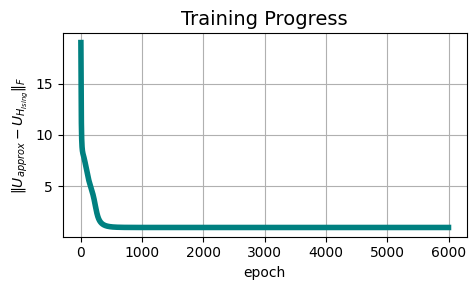

In [9]:
y = energies

fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)  # Increased the size for better visibility

ax.set_title('Training Progress', fontsize=14)  # Larger title font
ax.plot(y, color='teal', linestyle='-', linewidth=4)  # Blue line with a solid style and thicker line

ax.set_ylabel("$\| U_{approx} - U_{H_{Ising}} \|_{F}$", fontsize=10)  # Larger font for y-axis label
ax.set_xlabel("epoch", fontsize=10)  # Larger font for x-axis label

ax.grid(True)  # Adding gridlines

plt.tight_layout()
plt.show()


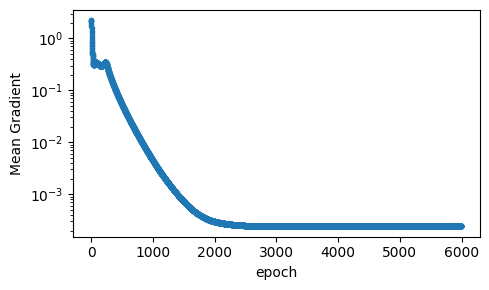

In [10]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

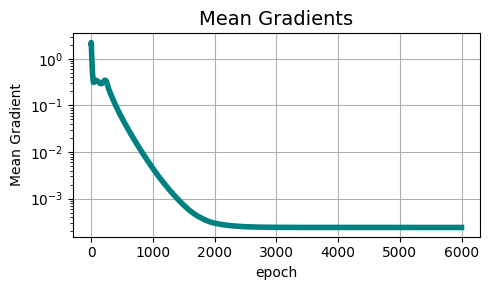

In [11]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# Plotting mean_gradients with a style similar to your example
ax.plot(mean_gradients, color='teal', linestyle='-', linewidth=4)  # Adjusted line style and color

ax.set_title('Mean Gradients', fontsize=14)  # Consistent title style
ax.set_yscale("log")  # Logarithmic y-scale
ax.set_ylabel("Mean Gradient", fontsize=10)  # Consistent y-label style
ax.set_xlabel("epoch", fontsize=10)  # Consistent x-label style

ax.grid(True)  # Adding gridlines for better readability

plt.tight_layout()
plt.show()

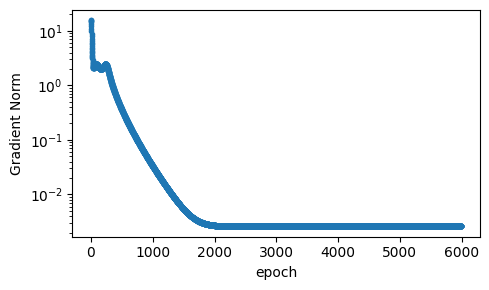

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

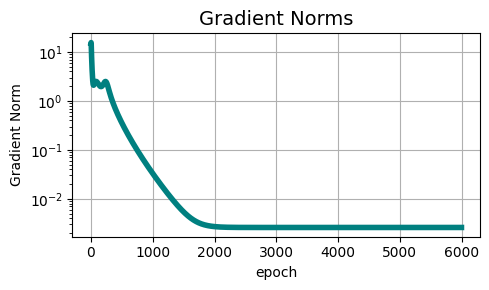

In [13]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, color='teal', linestyle='-', linewidth=4)  # Consistent style with previous example

ax.set_title('Gradient Norms', fontsize=14)  # Adding a title with a similar style
ax.set_yscale("log")  # Logarithmic scale for y-axis
ax.set_ylabel("Gradient Norm", fontsize=10)  # Consistent y-label style
ax.set_xlabel("epoch", fontsize=10)  # Consistent x-label style

ax.grid(True)  # Adding gridlines for readability

plt.tight_layout()
plt.show()

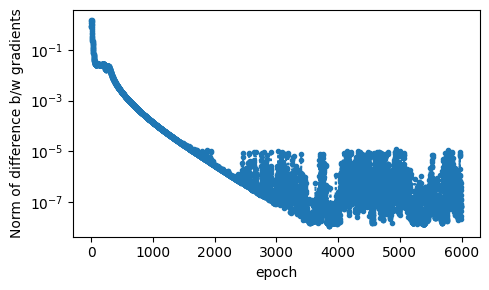

In [14]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1,len(gradients_trajectory))]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Norm of difference b/w gradients")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

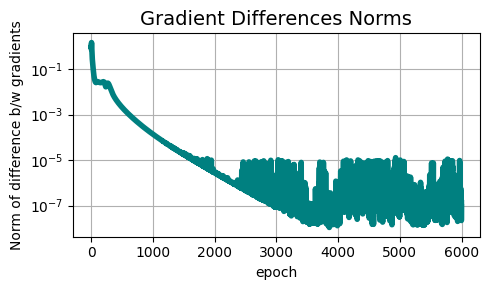

In [15]:
y = [np.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1, len(gradients_trajectory))]

fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# Plotting the norm of difference between gradients
ax.plot(y, color='teal', linestyle='-', linewidth=4)  # Consistent style with previous examples

ax.set_title('Gradient Differences Norms', fontsize=14)  # Adding a title with a similar style
ax.set_yscale("log")  # Logarithmic scale for y-axis
ax.set_ylabel("Norm of difference b/w gradients", fontsize=10)  # Consistent y-label style
ax.set_xlabel("epoch", fontsize=10)  # Consistent x-label style

ax.grid(True)  # Adding gridlines for readability

plt.tight_layout()
plt.show()

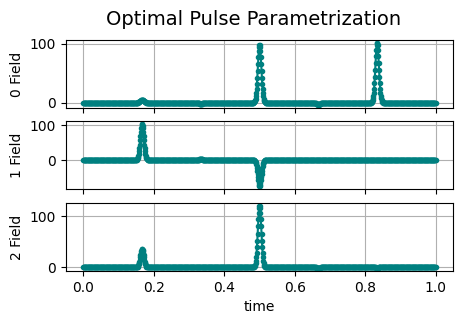

In [16]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, figsize=(5, 3), sharex=True)  # Adjusted figure size

fig.suptitle('Optimal Pulse Parametrization', fontsize=14)  # Larger title font

colors = ['teal', 'orange']  # Different colors for different plots

for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-", color='teal')
    ax.set_ylabel(f"{i} Field", fontsize=10)  # Set label with increased font size

    ax.grid(True)  # Adding gridlines

# Set label for the last plot
axs[-1].set_xlabel("time", fontsize=10)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust tight_layout to accommodate the suptitle
plt.show()


In [17]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 3.99669989e+02+0.j,  3.51744416e+02+0.j,  3.17890917e+02+0.j,
        2.95357887e+02+0.j,  2.63675883e+02+0.j,  2.83106930e+02+0.j,
        2.79475098e+02+0.j,  2.06247901e+02+0.j,  2.41160751e+02+0.j,
        2.41318007e+02+0.j,  1.54386158e+02+0.j,  1.58897481e+02+0.j,
        1.06744440e+02+0.j,  1.01240531e+02+0.j,  9.20222838e+01+0.j,
        8.25739199e+01+0.j,  8.12875497e+01+0.j,  7.19839917e+01+0.j,
        7.35936018e+01+0.j,  6.58223638e+01+0.j,  4.78148507e+01+0.j,
        1.72282791e+01+0.j,  1.34399176e+01+0.j,  1.19872739e+01+0.j,
        1.12507176e+01+0.j,  1.09884649e+01+0.j,  8.20450859e+00+0.j,
        5.18592065e+00+0.j,  4.84174257e+00+0.j,  3.71060534e+00+0.j,
        2.15988382e+00+0.j,  1.98853731e+00+0.j,  1.83686523e+00+0.j,
        1.67595107e+00+0.j, -1.15150386e+00+0.j,  1.26137637e+00+0.j,
        1.10070716e+00+0.j,  9.40366136e-01+0.j,  7.44448150e-01+0.j,
        6.76203739e-01+0.j,  4.88849947e-01+0.j,  3.81124488e-01+0.j,
       -3.81600396e-

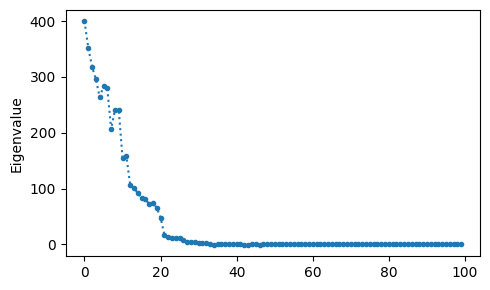

In [18]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()
y

plt.tight_layout()
plt.show()

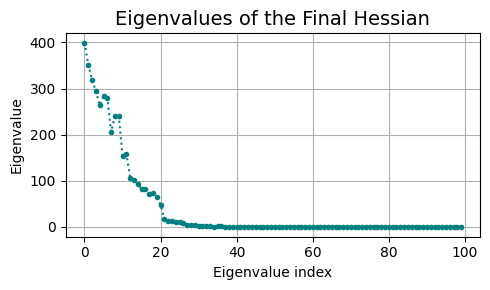

In [19]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = np.linalg.eigvals(final_hessian)

ax.plot(y, ".:", color='teal')  # Use a teal color with a dot-and-dash line style
ax.set_ylabel("Eigenvalue", fontsize=10)  # Set y-axis label with a larger font
ax.set_xlabel("Eigenvalue index", fontsize=10) 
# Uncomment the next line if a log scale is appropriate for your data
# ax.set_yscale("log")

ax.set_title("Eigenvalues of the Final Hessian", fontsize=14)  # Add a title

ax.grid(True)  # Add gridlines

plt.tight_layout()
plt.show()
